### Titli's code for tanimoto_dist_plot

In [37]:
# @Jessica: this cell is only for your reference.
# I have copied this function from AMPL, made some changes and called this function from here to check.
# Ideally, once I pushed mu changes to AMPL, you should be able to simply call the function from AMPL modules

import logging
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoDistMat

from atomsci.ddm.utils import struct_utils
from atomsci.ddm.pipeline import dist_metrics as dm

def plot_tani_dist_distr(df, smiles_col, df_name, radius=2, subset_col='subset', subsets=False, 
                         ref_subset='train', plot_width=6, ndist_max=None,**metric_kwargs):
    """
    Generate a density plot showing the distribution of nearest neighbor distances between 
    ecfp feature vectors, using the Tanimoto metric. Optionally split by subset.
    Args:
        df (DataFrame): A data frame containing, at minimum, a column of SMILES strings.
        smiles_col (str): Name of the column containing SMILES strings.
        df_name (str): Name for the dataset, to be used in the plot title.
        radius (int): Radius parameter used to calculate ECFP fingerprints. The default is 2, meaning that ECFP4
        fingerprints are calculated.
        subset_col (str): Name of the column containing subset names.
        subsets (bool): If True, distances are only calculated for compounds not in the reference subset, and the
        distances computed are to the nearest neighbors in the reference subset.
        ref_subset (str): Reference subset for nearest-neighbor distances, if `subsets` is True.
        plot_width (float): Plot width in inches.
        ndist_max (int): Not used, included only for backward compatibility.
        metric_kwargs: Additional arguments to pass to metric. Not used, included only for backward compatibility.
    Returns:
        dist (DataFrame): Table of individual nearest-neighbor Tanimoto distance values. If subsets is True,
        the table will include a column indicating the subset each compound belongs to.
    """
    log = logging.getLogger('ATOM')
    num_cmpds = len(df)
    # TODO: Make max compounds a parameter, rather than hardcoding to 50000. Better yet, calculate a sample
    # of distances of size ndist_max for each non-reference subset, and plot KDEs based on the samples.
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        #dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type='nearest', num_nearest=num_nearest)
        dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type='all')
        print(len(smiles_arr1), dists.shape)
        # flatten dists
        dists = dists.flatten()
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset: continue
            smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
            smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
            #diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='nearest', num_nearest=num_nearest)
            diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type='all')
            print(subs, diststmp.shape)
            # flatten dists
            diststmp = diststmp.flatten()
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist','subset'])
            dists=pd.concat([dists,diststmp]) 
    dists=dists.reset_index(drop=True)
    #print(dists)
    fig, ax = plt.subplots(figsize=(plot_width, plot_width))
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue='subset', legend=True, common_norm=False, common_grid=True, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name} dataset: Distribution of {dist_metric} distances\nbetween {feat_type} feature vectors from non-{ref_subset} subsets\nto their nearest neighbors in the {ref_subset} subset")
    return dists

In [42]:
home_dir = '/usr/WS2/atom/titli/MoDaC/Data/CYP2D6-ampl-1.1.0/'
train = pd.read_csv( home_dir + 'cyp2d6_union_trainset_base_smiles.csv')
test = pd.read_csv( home_dir + 'cyp2d6_union_testset_base_smiles.csv')
print(train.shape, test.shape)

(10445, 5) (1843, 5)


In [43]:
train.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,COCCOc1ccn2c(-c3ccc4cccc(OC5CCNCC5)c4n3)cnc2c1,CHEMBL3109340,5.00000,NaN,1
1,CN1CCC[C@@H](CC2c3ccccc3Sc3ccccc32)C1,MJFJKKXQDNNUJF-HNNXBMFYNA-N,6.50004,NaN,1


In [44]:
test.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,S=C(Nc1ccc2cn[nH]c2c1)Nc1ccc2cn[nH]c2c1,OTJWJLLGPAFTIP-KNLWZTMUNA-N,5.7,NaN,1
1,Cc1[nH]c2ccccc2c1C(c1ccccn1)N1CCC(C)CC1,NBKDMBGWUXYCJB-UHFFFAOYNA-N,4.6,<,0


In [39]:
# getting only 10 compounds for testing the func
df = train[:10]
df

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,COCCOc1ccn2c(-c3ccc4cccc(OC5CCNCC5)c4n3)cnc2c1,CHEMBL3109340,5.000000,NaN,1
1,CN1CCC[C@@H](CC2c3ccccc3Sc3ccccc32)C1,MJFJKKXQDNNUJF-HNNXBMFYNA-N,6.500040,NaN,1
2,O=C(Nc1ccc(S(=O)(=O)N2CC3CCC(C2)O3)cc1)[C@@H]1...,CHEMBL3127525,5.000000,<,0
3,O=C(O)C(Cc1ccc(-n2c(C3(C(F)(F)F)CC3)nc3cccnc32...,JHBJKRQQEIQKHE-IBGZPJMESA-N,4.000000,>,1
4,Cc1nc2ccccc2n1C1CCN(CCC(c2ccccc2)c2ccccc2)CC1,CHEMBL3799799,7.397940,NaN,1
5,Cc1cc(C)n2nc(CC3=C(O)CC(CCc4ccc(C(C)(C)C#N)c(C...,CHEMBL230743,5.408935,NaN,1
6,O=C1CC(=Nc2ccc(Cl)cc2)CC(c2ccc(Cl)cc2)C1,AFJKHYPUJGRPFI-UHFFFAOYNA-N,5.050000,NaN,1
7,COC(=O)C1(Cc2ccccc2)CC2=C(C=N1)C(C)C(=O)C2C,XIGCHYCYSWFBIX-UHFFFAOYNA-N,4.800000,<,0
8,NCc1noc(-c2c3ccccc3nn2Cc2ccccc2)n1,CHEMBL466715,5.000000,NaN,1
9,O=C1c2cc(Cl)cc3cnn(c23)CCN1C1CN2CCC1CC2,JBVRKZZSTULWTO-OAHLLOKOSA-N,4.301030,>,1


# Compare Titli's modified function with AMPL (on same data)

### a. Compare subset=False part (1st)

10 (10, 10)


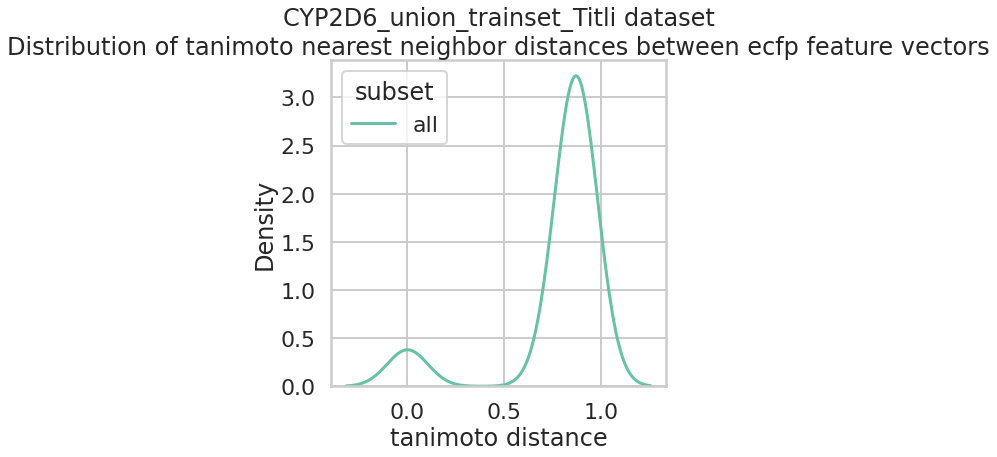

In [27]:
# call Titli's modified function
dists = plot_tani_dist_distr(df, 'base_rdkit_smiles', df_name='CYP2D6_union_trainset_Titli', subsets=False, out_dir=home_dir)

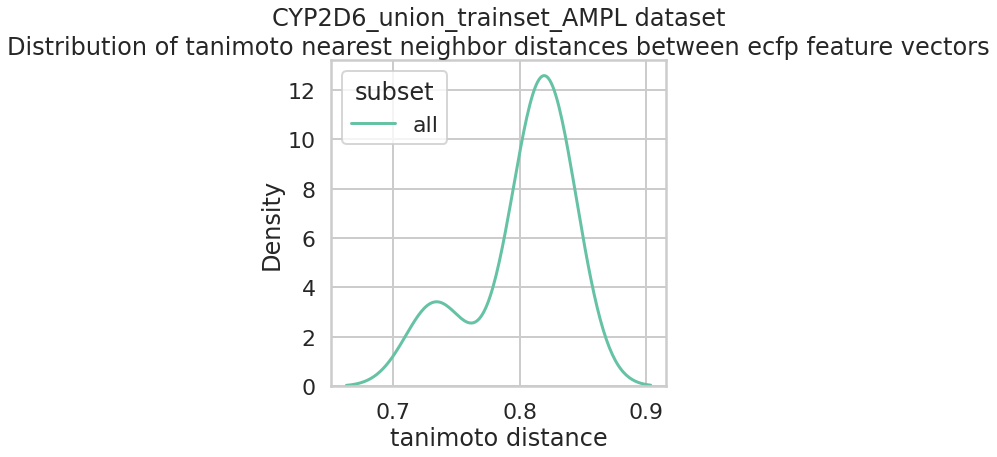

In [28]:
# call AMPL's function
import atomsci.ddm.pipeline.diversity_plots as dp
dists1 = dp.plot_tani_dist_distr(df, 'base_rdkit_smiles', df_name='CYP2D6_union_trainset_AMPL', subsets=False, out_dir=home_dir)

In [29]:
print(dists.shape, dists1.shape)

(100, 2) (10, 2)


### b. Compare subset=True part (2nd)

In [45]:
# here, we use the full dataframe, as the split file do not have 'base_smiles' column, which is required for the function, 
# we merge train, test and split file, in order to get the smiles column

home_dir = '/usr/WS2/atom/titli/MoDaC/Data/CYP2D6-ampl-1.1.0/'
dfSplit = pd.read_csv( home_dir + 'cyp2d6_union_combined_shuffled_train_valid_test_fingerprint_4cfc6dc0-c2b5-4765-bd8f-fbbc07f33b3c.csv')
print(dfSplit.shape)
dfSplit.head(2)

(12288, 3)


,cmpd_id,subset,fold
0,LNEQWVGUQLFTIF-UHFFFAOYNA-N,train,0
1,OIGHTPDWPMLMGT-UHFFFAOYNA-N,train,0


In [47]:
dfSplit.subset.value_counts() # note that it do not have SMILES column

train    8601
test     1844
valid    1843
Name: subset, dtype: int64

In [50]:
#we are merging union_train, union_test and split_file to get train-validation-test split on overall data
# merge all info together and cut out feature columns
pred_df=pd.concat([train,test])
pred_df=pred_df.merge(dfSplit, how='left', left_on='compound_id', right_on='cmpd_id')
pred_df.loc[pred_df.subset.isna(), 'subset']='test'
pred_df.subset.value_counts()
pred_df.head(2)

,base_rdkit_smiles,compound_id,pIC50,relation,active,cmpd_id,subset,fold
0,COCCOc1ccn2c(-c3ccc4cccc(OC5CCNCC5)c4n3)cnc2c1,CHEMBL3109340,5.00000,NaN,1,CHEMBL3109340,train,0
1,CN1CCC[C@@H](CC2c3ccccc3Sc3ccccc32)C1,MJFJKKXQDNNUJF-HNNXBMFYNA-N,6.50004,NaN,1,MJFJKKXQDNNUJF-HNNXBMFYNA-N,train,0


valid (1843, 8601)
test (1844, 8601)


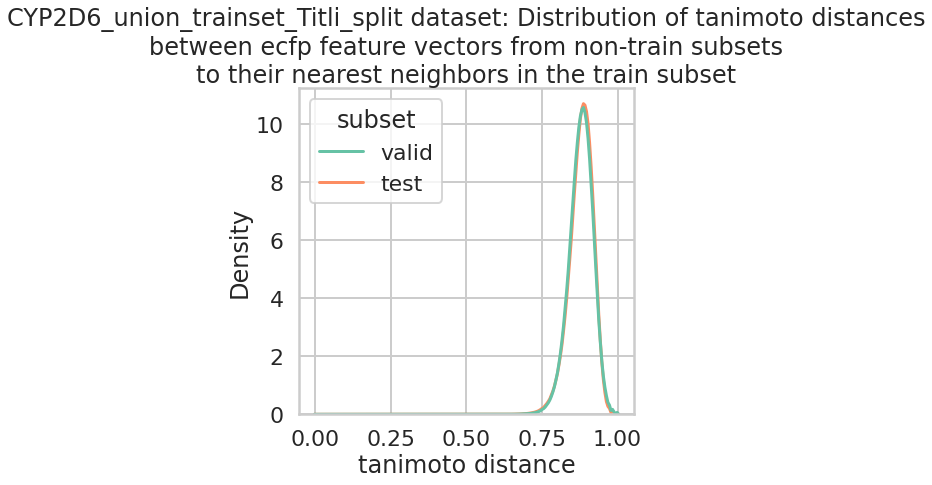

In [52]:
# call Titli's modified function
distSplit = plot_tani_dist_distr(pred_df, 'base_rdkit_smiles', df_name='CYP2D6_union_trainset_Titli_split', subsets=True, out_dir=home_dir)

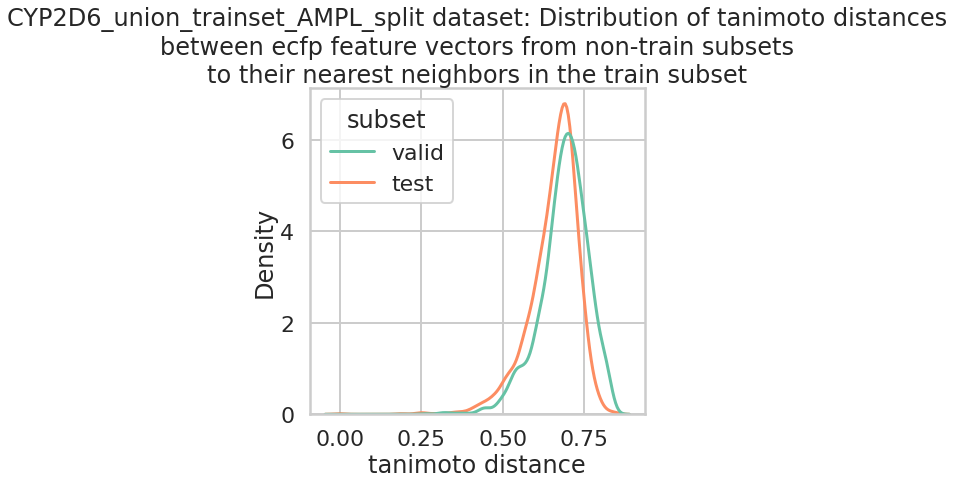

In [53]:
# call Titli's modified function
distSplit1 = dp.plot_tani_dist_distr(pred_df, 'base_rdkit_smiles', df_name='CYP2D6_union_trainset_AMPL_split', subsets=True, out_dir=home_dir)

In [54]:
print(distSplit.shape, distSplit1.shape)

(31711887, 2) (3687, 2)
